## tensorflow实现情感分析

In [1]:
# 导包
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from gensim.models import KeyedVectors

import re
import os


In [2]:
# 使用gensim加载预训练中文分词，需要等待一段时间
cn_model = KeyedVectors.load_word2vec_format('vectors/sgns.zhihu.bigram',
                                            binary=False, unicode_errors='ignore')

In [3]:
# 读取训练数据
pos_file_list = os.listdir('data/pos')
neg_file_list = os.listdir('data/neg')
pos_file_list = [f'data/pos/{x}' for x in pos_file_list]
neg_file_list = [f'data/neg/{x}' for x in neg_file_list]
pos_neg_file_list = pos_file_list + neg_file_list

In [4]:
# 读取所有的文本，放入到x_train,前3000是正向样本，后3000负向样本
x_train = []
for file in pos_neg_file_list:
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read().strip()
        pass
    x_train.append(text)
    pass


In [5]:
x_train = np.array(x_train)
y_train = np.concatenate((np.ones(3000), np.zeros(3000)))  # 生成标签


In [6]:
# 打乱训练样本和标签的顺序
np.random.seed(116)
np.random.shuffle(x_train)

np.random.seed(116)
np.random.shuffle(y_train)

In [7]:
# 进行分词操作
x_train_tokens = []
for text in x_train:
    # 去掉标点
    # text = re.sub("[\s+.!/_,$%^(+\"']+|[+——！，。？、~@#￥%……&（）]+", "", text)
    cut = jieba.cut(text)
    cut_list = [x for x in cut]
    for i,word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
            pass
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
            pass   
        pass
    x_train_tokens.append(cut_list)
    pass

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Gxt\AppData\Local\Temp\jieba.cache
Loading model cost 0.520 seconds.
Prefix dict has been built successfully.


In [8]:
# 索引长度标准化
# 因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评语填充成同样的长度，
# 这样十分浪费计算资源，所以我们去一个折衷的长度
tokens_count = [len(tokens) for tokens in x_train_tokens]
tokens_count.sort(reverse=True)



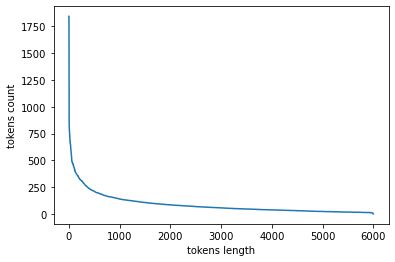

In [9]:

# 画图查看词的长度分布
plt.plot(tokens_count)
plt.ylabel('tokens count')
plt.xlabel('tokens length')
plt.show()
# 可以看出大部分词的长度都是在500以下的

In [10]:
# 当tokens长度分布满足正态分布的时候，
# 可以使用 取tokens的平均值并且加上两个tokens的标准差，来选用tokens的长度
tokens_length = np.mean(tokens_count) + 2 * np.std(tokens_count)
tokens_length

297.3980831340084

In [11]:


# 可以看到当tokens的长度为244，大约95%的样本被覆盖，
# 我们需要对长度不足的tokens进行padding，超长的进行修剪
np.sum(tokens_count < tokens_length) / len(tokens_count)

0.9545

In [12]:
# 定义一个把tokens转换成文本的方法
def reverse_tokens(tokens):
    text = ''
    for index in tokens:
        if index != 0:
            text = text + cn_model.index2word[index]
        else:
            text = text + ''
        pass
    return text
    pass

In [13]:
print(reverse_tokens(x_train_tokens[0]))
y_train[0]

酒店的服务简直不好程度排第一！我住1702房间漏风。调整到1710房间！这个房间的空调是坏的！半夜给了。调整到房间明显比1702和1710房间小的很多而且房间不能够上网我已经被折磨的没有力气在调整房间了。想躺在床上看看电视我的天啊！看不了！总之我对这次携程的服务比较满意对该辽宁省沈阳市城市酒店提供的客房服务是特别特别特别的不满意！我希望携程能够好好考虑一下自己的加盟酒店总是这样我们还怎么相信携程这样的品牌。总体来说我很郁闷！也特别的伤心！


0.0

In [14]:
embedding_matrix = np.zeros((50000, 300))
for i in range(50000):
    embedding_matrix[i, :] = cn_model[cn_model.index2word[i]]
    pass
embedding_matrix = embedding_matrix.astype('float32')


In [15]:
x_train_tokens_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_tokens,
                                                                  maxlen=int(tokens_length),
                                                                  padding='pre',
                                                                  truncating='pre')

In [16]:
x_train_tokens_pad[x_train_tokens_pad >= 50000] = 0
# x_train_tokens_pad.shape
np.sum(cn_model[cn_model.index2word[300]] == embedding_matrix[300])


300

In [17]:
# 使用90%进行训练，10%进行测试
# x_tokens_train = x_train_tokens_pad[:-int(x_train_tokens_pad.shape[0] / 10)]
# x_tokens_test = x_train_tokens_pad[-int(x_train_tokens_pad.shape[0] / 10):]
# y_tokens_train = y_train[:-int(y_train.shape[0] / 10)]
# y_tokens_test = y_train[-int(y_train.shape[0] / 10):]
from sklearn.model_selection import train_test_split
x_tokens_train, x_tokens_test, y_tokens_train, y_tokens_test = train_test_split(
    x_train_tokens_pad,
    y_train,
    test_size=0.1,
    random_state=12
)

In [18]:
x_tokens_train.shape
embedding_matrix.shape

(50000, 300)

In [84]:
# 构建模型
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(50000,300,                          
                              weights=[embedding_matrix],
                              input_length=int(tokens_length),
                              trainable=False,
                                        ),
#     tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            units=64, return_sequences=True 
        )),
    tf.keras.layers.LSTM(32, return_sequences=False),
#     tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy']
             )
# , kernel_regularizer=tf.keras.regularizers.l2(0.01)

In [85]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 297, 300)          15000000  
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 297, 128)          186880    
_________________________________________________________________
lstm_36 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 66        
Total params: 15,207,554
Trainable params: 207,554
Non-trainable params: 15,000,000
_________________________________________________________________


In [86]:
history = model.fit(x_tokens_train, 
          y_tokens_train,
          batch_size=128,
          epochs=40, 
          validation_split=0.1,
          validation_freq=1
         )

Epoch 1/40
38/38 [==============================] - 110s 3s/step - loss: 0.5623 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.4537 - val_sparse_categorical_accuracy: 0.7815
Epoch 2/40
38/38 [==============================] - 113s 3s/step - loss: 0.4334 - sparse_categorical_accuracy: 0.8099 - val_loss: 0.3983 - val_sparse_categorical_accuracy: 0.8333
Epoch 3/40
38/38 [==============================] - 113s 3s/step - loss: 0.3890 - sparse_categorical_accuracy: 0.8325 - val_loss: 0.3919 - val_sparse_categorical_accuracy: 0.8370
Epoch 4/40
38/38 [==============================] - 111s 3s/step - loss: 0.3643 - sparse_categorical_accuracy: 0.8479 - val_loss: 0.3370 - val_sparse_categorical_accuracy: 0.8500
Epoch 5/40
38/38 [==============================] - 104s 3s/step - loss: 0.2912 - sparse_categorical_accuracy: 0.8883 - val_loss: 0.3595 - val_sparse_categorical_accuracy: 0.8611
Epoch 6/40
38/38 [==============================] - 108s 3s/step - loss: 0.3268 - sparse_categorical_accu

In [87]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 297, 300)          15000000  
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 297, 128)          186880    
_________________________________________________________________
lstm_36 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 66        
Total params: 15,207,554
Trainable params: 207,554
Non-trainable params: 15,000,000
_________________________________________________________________


In [88]:
result = model.evaluate(x_tokens_test, y_tokens_test)
print(f'Accuracy : {result[1]}')

19/19 [==============================] - 6s 339ms/step - loss: 0.5709 - sparse_categorical_accuracy: 0.9150
Accuracy : 0.9150000214576721


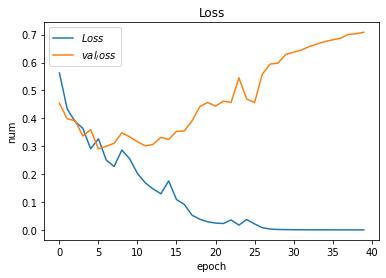

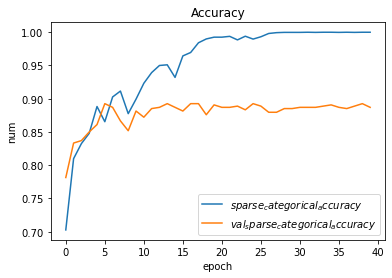

In [89]:
# history.history['loss']
# history.history['val_loss']
# history.history['sparse_categorical_accuracy']
# history.history['val_sparse_categorical_accuracy']
plt.plot(history.history['loss'],label="$Loss$")
plt.plot(history.history['val_loss'],label='$val_loss$')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('num')
plt.legend()
plt.show()
plt.plot(history.history['sparse_categorical_accuracy'],label="$sparse_categorical_accuracy$")
plt.plot(history.history['val_sparse_categorical_accuracy'],label='$val_sparse_categorical_accuracy$')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('num')
plt.legend()
plt.show()

In [90]:
def predict_sentiment(text):
    
    print(text)
    text = re.sub("[\s+.!/_,$%^(+\"'\”\“]+|[+——！，。？、~@#￥%……&（）]+", "", text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [x for x in cut]
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
        pass
    # padding
    tokens_pad = tf.keras.preprocessing.sequence.pad_sequences([cut_list],
                                                                  maxlen=int(tokens_length),
                                                                  padding='pre',
                                                                  truncating='pre')
    return tokens_pad
    pass

In [93]:
test_list = [
'酒店设施不是新的，服务态度很不好',
'酒店卫生条件非常不好',
'床铺非常舒适',
'房间很冷，还不给开暖气',
'房间很凉爽，空调冷气很足',
'酒店环境不好，住宿体验很不好',
'房间隔音不到位' ,
'晚上回来发现没有打扫卫生,心情不好',
'因为过节所以要我临时加钱，比团购的价格贵',
'房间很温馨，前台服务很好,',
'国庆出游人比较多，各个景点都是，这个时候能欣赏到风景就不错了。行程整体比较满意，希望酒店可以稍微离市区近点就更完美了'
]

In [94]:
for text in test_list:
    try:
        tokens_pad = predict_sentiment(text)
        result = model.predict(x=tokens_pad)
        print(result)
        if result[0][0] <= result[0][1]:
            print(f'正:{result[0][1]}')
        else:
            print(f'负:{result[0][0]}')
    except Exception as ex:
        print(ex.args)
        pass
    pass

酒店设施不是新的，服务态度很不好
[[0.98101556 0.01898442]]
负:0.9810155630111694
酒店卫生条件非常不好
[[9.9976319e-01 2.3681107e-04]]
负:0.9997631907463074
床铺非常舒适
[[0.00251764 0.99748236]]
正:0.9974823594093323
房间很冷，还不给开暖气
[[0.00424713 0.99575293]]
正:0.9957529306411743
房间很凉爽，空调冷气很足
[[5.4499478e-04 9.9945503e-01]]
正:0.9994550347328186
酒店环境不好，住宿体验很不好
[[9.9991775e-01 8.2195154e-05]]
负:0.99991774559021
房间隔音不到位
[[0.96766675 0.03233326]]
负:0.967666745185852
晚上回来发现没有打扫卫生,心情不好
[[0.9203221  0.07967793]]
负:0.9203221201896667
因为过节所以要我临时加钱，比团购的价格贵
[[0.99784744 0.00215254]]
负:0.9978474378585815
房间很温馨，前台服务很好,
[[8.8387911e-05 9.9991155e-01]]
正:0.9999115467071533
国庆出游人比较多，各个景点都是，这个时候能欣赏到风景就不错了。行程整体比较满意，希望酒店可以稍微离市区近点就更完美了
[[3.953311e-05 9.999604e-01]]
正:0.9999604225158691


In [223]:
embedding_matrix = np.zeros((50000, 300))
for i in range(50000):
    embedding_matrix[i, :] = cn_model[cn_model.index2word[i]]
    pass
embedding_matrix = embedding_matrix.astype('float32')


In [224]:
# 使用LSTM对样本进行分类
model_lstm = tf.keras.models.Sequential()
tokens_length

244.26095871510626

In [225]:
# 构建第一层embedding
model_lstm.add(tf.keras.layers.Embedding(50000,300,
                                         weights=[embedding_matrix],
                                         input_length=int(tokens_length),
                                         trainable=False                                        
                                        ))

In [226]:
model_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)))
model_lstm.add(tf.keras.layers.LSTM(units=16, return_sequences=False))

In [227]:
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [228]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                   loss='binary_crossentropy',
                   metrics=['accuracy']
                  )

In [229]:
model_lstm.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 244, 300)          15000000  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 244, 128)          186880    
_________________________________________________________________
lstm_18 (LSTM)               (None, 16)                9280      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 17        
Total params: 15,196,177
Trainable params: 196,177
Non-trainable params: 15,000,000
_________________________________________________________________


In [230]:
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                                verbose=1, save_weights_only=True,
                                                save_best_only=True
                                               )

In [231]:
# 定义darly stroping如果3个epoch内validation loss没有改善，则停止训练
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                                verbose=1)

In [232]:
# 自动降低learing rate
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.1, min_lr=1e-8, 
                                                    patience=0, verbose=1
                                                   )

In [233]:
# 定义callback函数
callbacks = [
    earlystopping,
    checkpoint,
    lr_reduction
]
x_tokens_train

array([[    0,     0,     0, ...,   158,  8567,     0],
       [    0,     0,     0, ...,   153,  1097,     3],
       [    0,     0,     0, ...,   914,    40,   562],
       ...,
       [    0,     0,     0, ...,  2567,   582,  1923],
       [    0,     0,     0, ...,   348,     0,     1],
       [    0,     0,     0, ...,   568,    35, 11780]])

In [234]:
# 开始训练
model_lstm.fit(x_tokens_train, y_tokens_train, 
               validation_split=0.1,
               epochs=20, batch_size=128,
               callbacks=callbacks
              )

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.7208
Epoch 00001: val_loss improved from inf to 0.40546, saving model to sentiment_checkpoint.keras
38/38 [==============================] - 49s 1s/step - loss: 0.5437 - accuracy: 0.7208 - val_loss: 0.4055 - val_accuracy: 0.8204
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.7864
Epoch 00002: val_loss did not improve from 0.40546

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
38/38 [==============================] - 51s 1s/step - loss: 0.4432 - accuracy: 0.7864 - val_loss: 0.4629 - val_accuracy: 0.7667
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8218
Epoch 00003: val_loss improved from 0.40546 to 0.34328, saving model to sentiment_checkpoint.keras
38/38 [==============================] - 52s 1s/step - loss: 0.3899 - accuracy: 0.8218 - val_loss: 0.3433 - val_accuracy: 0.8574
Epoc

In [235]:
result = model_lstm.evaluate(x_tokens_test, y_tokens_test)
print(f'Accuracy : {result[1]}')

19/19 [==============================] - 2s 113ms/step - loss: 0.3276 - accuracy: 0.8583
Accuracy : 0.8583333492279053
